In [1]:
import torch as T
import torch.nn as nn
from draft_nn import Net, CMIPDataset
import numpy as np
ds = CMIPDataset([
    'cLeaf_Lmon_CESM2_land-hist_r1i1p1f1_gn_185001-201512.nc',
    'gpp_Lmon_CESM2_land-hist_r1i1p1f1_gn_185001-201512.nc',
    'rGrowth_Lmon_CESM2_land-hist_r1i1p1f1_gn_185001-201512.nc',
    'cVeg_Lmon_CESM2_land-hist_r1i1p1f1_gn_185001-201512.nc'],
    '/Users/gclyne/thesis/data/NABoreal.shp','/Users/gclyne/thesis/data/'
    )
ds.data = (ds.data - ds.data.mean()) / ds.data.std() #where should this be done? 

ds = T.utils.data.Subset(ds, list(range(0,100)))
train_set_size = int(len(ds) * 0.8)
valid_set_size = len(ds) - train_set_size
train,test = T.utils.data.random_split(ds, [train_set_size, valid_set_size], generator=T.Generator().manual_seed(42))

model = Net()
loss_function = nn.MSELoss()
learning_rate = 0.05
train_ldr = T.utils.data.DataLoader(train,batch_size=1,shuffle=True)
test_ldr = T.utils.data.DataLoader(test,batch_size=1,shuffle=True)
optimizer = T.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

/Users/gclyne/thesis/env/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'cLeaf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/gclyne/thesis/env/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'gpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/gclyne/thesis/env/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rGrowth' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/gclyne/thesis/env/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


tensor([[ 0.1466,  1.0493, -1.2175,  0.1441,  0.1441]], dtype=torch.float64) tensor([0.3090], grad_fn=<SelectBackward0>) tensor([0.3331], dtype=torch.float64)
grad None
0.0005815273034386337
grad None
tensor([[ 0.1470,  1.0493, -1.1679,  0.1441,  0.1441]], dtype=torch.float64) tensor([0.3114], grad_fn=<SelectBackward0>) tensor([0.3459], dtype=torch.float64)
grad None
0.001189477159641683
grad None
tensor([[ 0.1492,  1.1240, -1.5888,  0.1441,  0.1441]], dtype=torch.float64) tensor([0.3149], grad_fn=<SelectBackward0>) tensor([0.4095], dtype=torch.float64)
grad None
0.008953613229095936
grad None
tensor([[ 0.1479,  1.1240, -1.6383,  0.1441,  0.1441]], dtype=torch.float64) tensor([0.3243], grad_fn=<SelectBackward0>) tensor([0.3550], dtype=torch.float64)
grad None
0.000939429213758558
grad None
tensor([[ 0.1460,  1.0866, -1.6631,  0.1441,  0.1441]], dtype=torch.float64) tensor([0.3274], grad_fn=<SelectBackward0>) tensor([0.2921], dtype=torch.float64)
grad None
0.001248720451258123
grad None

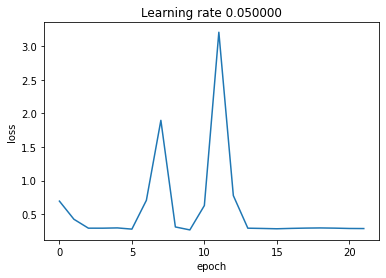

In [12]:
import matplotlib.pyplot as plt
min_valid_loss = np.inf
for epoch in range(2):
    train_loss = 0
    model.train()
    for X,y in train_ldr:
        pred_y = model(X.float())[0]

        print(X,pred_y,y)
        loss = loss_function(pred_y, y.float())
        optimizer.zero_grad() #clears old gradients from previous steps 
        loss.backward() #compute gradient
        optimizer.step() #take step based on gradient
        train_loss += loss.item()
        print(loss.item())

    losses.append(train_loss)


    model.eval()
    valid_loss = 0
    for X,y in test_ldr:
        pred_y = model(X.float())
        test_loss = loss_function(pred_y,y.float())
        valid_loss += test_loss.item() * X.size(0)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
        min_valid_loss = valid_loss
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()